# Avoid negative predictions when forecasting

When training a forecasting model, even though none of the training observations is negative, some predictions may turn out to be negative. To avoid this, it is possible to model the series on a logarithmic scale.

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
from sklearn.linear_model import Ridge
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

## Data

In [2]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url, usecols=['date_time', 'users'], nrows=1000)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()

In [3]:
# Split train-test
# ==============================================================================
end_train = '2011-01-31 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(f"Dates train: {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train: 2011-01-01 00:00:00 --- 2011-01-31 23:00:00  (n=744)
Dates test : 2011-02-01 00:00:00 --- 2011-02-11 15:00:00  (n=256)


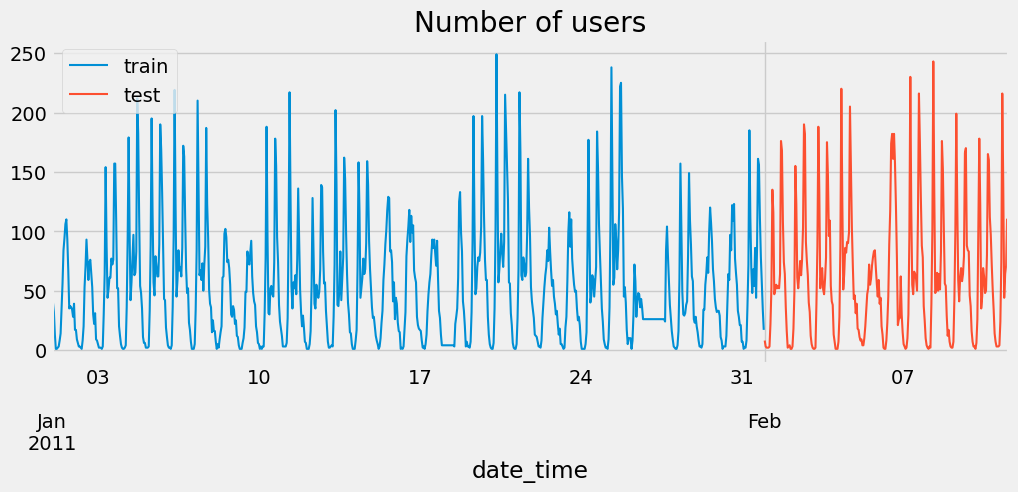

In [4]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_train['users'].plot(ax=ax, label='train')
data_test['users'].plot(ax=ax, label='test')
ax.set_title('Number of users')
ax.legend();

## Forecaster

In [5]:
# Create forecaster and train
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = Ridge(random_state=123),
                 lags      = 24
             )

In [6]:
# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True  
                      )

100%|██████████| 11/11 [00:00<00:00, 478.22it/s]


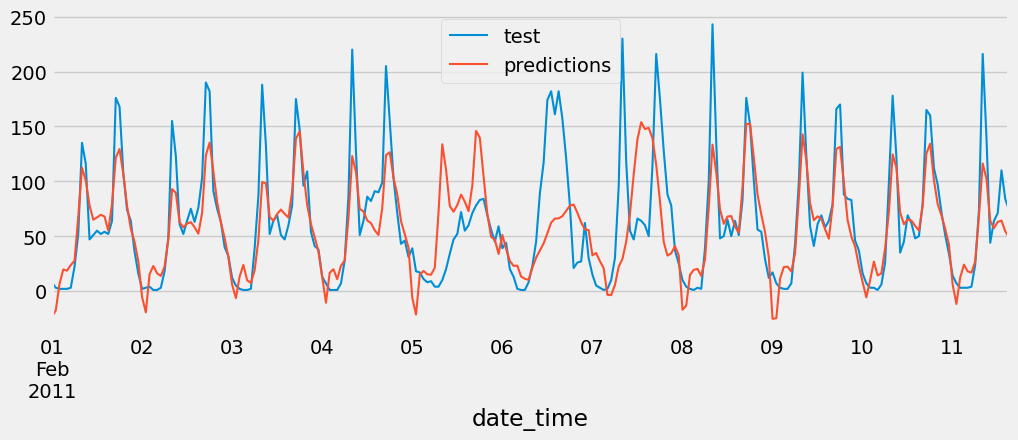

In [7]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

The graph above shows that some predictions are negative.

In [8]:
# Negative predictions
predictions[predictions.pred < 0]

,pred
2011-02-01 00:00:00,-23.337236
2011-02-01 01:00:00,-17.691405
2011-02-02 00:00:00,-5.243456
2011-02-02 01:00:00,-19.363139
2011-02-03 01:00:00,-6.441943
2011-02-04 01:00:00,-10.579940
2011-02-05 00:00:00,-6.026119
2011-02-05 01:00:00,-21.396841
2011-02-07 04:00:00,-3.412043
2011-02-07 05:00:00,-3.701964


## Modeling time series in logarithmic scale

In [9]:
# Transform data into logarithmic scale
# =============================================================================
data_log = np.log1p(data)
data_train_log = np.log1p(data_train)
data_test_log  = np.log1p(data_test)

In [10]:
# Create forecaster and train
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24,
             )

# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data_log['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data_log.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True  
                      )

100%|██████████| 11/11 [00:00<00:00, 549.92it/s]


In [11]:
# Revert the transformation
# ==============================================================================
predictions = np.expm1(predictions)
predictions.head(4)

,pred
2011-02-01 00:00:00,7.936823
2011-02-01 01:00:00,4.210682
2011-02-01 02:00:00,3.009993
2011-02-01 03:00:00,3.083922


In [12]:
metric = mean_squared_error(y_true=data_test['users'], y_pred=predictions)
print(f"Backtesting metric: {metric}")

Backtesting metric: 1991.9332571759883


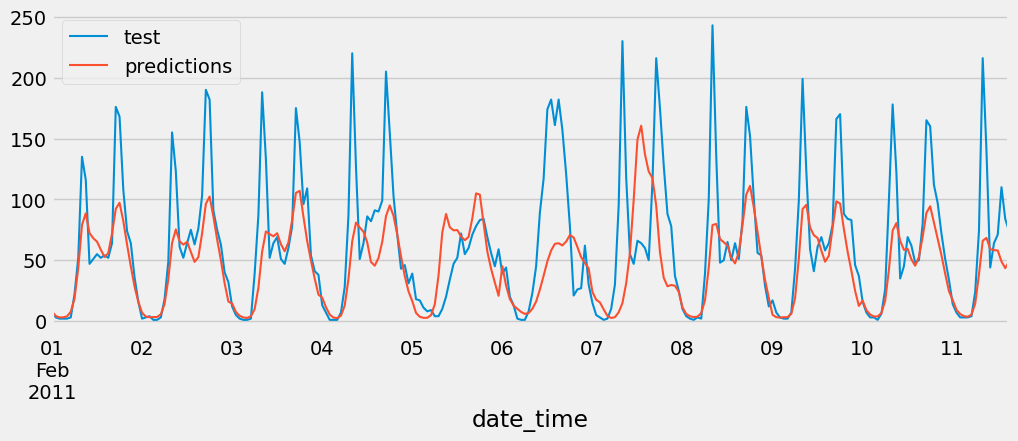

In [13]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

## Include a logarithmic transformer as part of the forecaster

Using scikit-learn [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) it is possible to include custom transformers in the forecaster object, for example, a logarithmic transformation. If the `FunctionTransformer` has an inverse function, the output of the predict method is automatically transformed back to the original scale.

In [14]:
# Create custom transformer
# =============================================================================
transformer_y = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

# Create forecaster and train
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = Ridge(random_state=123),
                 lags             = 24,
                 transformer_y    = transformer_y,
                 transformer_exog = None
             )
forecaster.fit(data['users'])

# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True  
                      )

print(f"Backtesting metric: {metric}")
predictions.head()

100%|██████████| 11/11 [00:00<00:00, 458.28it/s]

Backtesting metric: 1991.9332571759883


,pred
2011-02-01 00:00:00,7.936823
2011-02-01 01:00:00,4.210682
2011-02-01 02:00:00,3.009993
2011-02-01 03:00:00,3.083922
2011-02-01 04:00:00,3.865169


In [15]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>